<a href="https://colab.research.google.com/github/scottwmwork/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [174]:
# TODO - your code!
!wget https://raw.githubusercontent.com/scottwmwork/datasets/master/house-votes-84.data

--2019-08-21 20:54:40--  https://raw.githubusercontent.com/scottwmwork/datasets/master/house-votes-84.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [text/plain]
Saving to: ‘house-votes-84.data.2’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.007s  

2019-08-21 20:54:41 (2.52 MB/s) - ‘house-votes-84.data.2’ saved [18171/18171]



In [0]:
import pandas as pd
df = pd.read_csv("house-votes-84.data", header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])

In [0]:
import numpy as np
df = df.replace({'?':np.NaN, 'n':0, 'y':1})
df.fillna(method = 'bfill');
df.fillna(method = 'ffill');

In [0]:
rep = df[df["party"] == "republican"]
dem = df[df["party"] == "democrat"]

In [178]:
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [0]:
from scipy import stats
def confidence_interval(data, confidence_level=0.95):
  data = data.dropna()
  sample_mean = np.mean(data) 
  sample_size = len(data)
  sample_std_dev = np.std(data, ddof=1)
  standard_error = sample_std_dev / (sample_size**.5)
  margin_of_error = standard_error * stats.t.ppf((1 + confidence_level) / 2.0, sample_size - 1)
  return (sample_mean, sample_mean - margin_of_error, sample_mean + margin_of_error)

In [180]:
confidence_interval(rep["budget"])

(0.13414634146341464, 0.0814352013169756, 0.1868574816098537)

In [0]:
#Now we want to plot the CI for each column for each party!
#Step 1: combine CI for republican and combine CI for republicans
rep_ci = pd.DataFrame()
names = ['handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

#create index for dataframe
rep_ci['issue'] = names

mean = []
lower = []
upper = []

#make lists of mean, lower, and upper bounds for all issues
for name in names:
  tup = confidence_interval(rep[name])
  mean.append(tup[0]) 
  lower.append(tup[1])
  upper.append(tup[2])

#add lists to dataframe  
rep_ci['mean'] = mean
rep_ci['lower'] = lower
rep_ci['upper'] = upper

In [182]:
rep_ci #Show Dataframe from republican confidence intervals

,issue,mean,lower,upper
0,handicapped-infants,0.187879,0.127652,0.248106
1,water-project,0.506757,0.425266,0.588248
2,budget,0.134146,0.081435,0.186857
3,physician-fee-freeze,0.987879,0.971007,1.004751
4,el-salvador-aid,0.951515,0.918398,0.984632
5,religious-groups,0.897590,0.850987,0.944193
6,anti-satellite-ban,0.240741,0.174201,0.307281
7,aid-to-contras,0.152866,0.095955,0.209778
8,mx-missile,0.115152,0.065935,0.164368
9,immigration,0.557576,0.480996,0.634156


In [0]:
#Creating dataframe out of democrat CI
dem_ci = pd.DataFrame()
names = ['handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

#create index for dataframe
dem_ci['issue'] = names

mean = []
lower = []
upper = []

#make lists of mean, lower, and upper bounds for all issues
for name in names:
  tup = confidence_interval(dem[name])
  mean.append(tup[0]) 
  lower.append(tup[1])
  upper.append(tup[2])

#add lists to dataframe  
dem_ci['mean'] = mean
dem_ci['lower'] = lower
dem_ci['upper'] = upper

In [184]:
dem_ci #Show Dataframe from democrat confidence intervals

,issue,mean,lower,upper
0,handicapped-infants,0.604651,0.544593,0.664710
1,water-project,0.502092,0.438245,0.565939
2,budget,0.888462,0.849944,0.926980
3,physician-fee-freeze,0.054054,0.026332,0.081776
4,el-salvador-aid,0.215686,0.164863,0.266509
5,religious-groups,0.476744,0.415392,0.538097
6,anti-satellite-ban,0.772201,0.720782,0.823620
7,aid-to-contras,0.828897,0.783085,0.874710
8,mx-missile,0.758065,0.704394,0.811735
9,immigration,0.471483,0.410757,0.532208


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


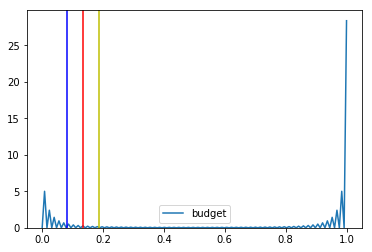

In [185]:
# Graphically (with a plot) represent a confidence interval
budget_rep_ci = confidence_interval(rep["budget"])
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(rep["budget"])
plt.axvline(x = budget_rep_ci[0], color = 'r') #mean
plt.axvline(x = budget_rep_ci[1], color = 'b') #upper
plt.axvline(x = budget_rep_ci[2], color = 'y') #lower

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


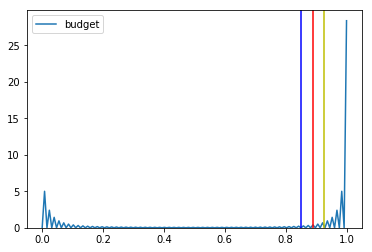

In [186]:
# Graphically (with a plot) represent a confidence interval
budget_dem_ci = confidence_interval(dem["budget"])
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(rep["budget"])
plt.axvline(x = budget_dem_ci[0], color = 'r') #mean
plt.axvline(x = budget_dem_ci[1], color = 'b') #upper
plt.axvline(x = budget_dem_ci[2], color = 'y') #lower

In [194]:
votes_no_rep = 0
votes_yes_rep = 0
votes_no_dem = 0
votes_yes_dem = 0
for name in names:
  votes_no_rep = votes_no + rep[name].value_counts().tolist()[0]
  votes_no_dem = votes_no + dem[name].value_counts().tolist()[0]
  votes_yes_rep = votes_yes + rep[name].value_counts().tolist()[1]
  votes_yes_dem = votes_yes + dem[name].value_counts().tolist()[1]

print("Total Votes Yes Democrat: ", votes_yes_dem)
print("Total Votes no Democrat: ", votes_no_dem)
print("Total Votes yes Republican: ", votes_yes_rep)
print("Total Votes no Republican: ", votes_no_rep)

Total Votes Yes Democrat:  353
Total Votes no Democrat:  1483
Total Votes yes Republican:  353
Total Votes no Republican:  1483


##X squared tests##

In [201]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.describe(exclude='number')
cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)
df = df.sort_values(by='hours_per_week_categories', ascending=True)
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)
femalecount = contingency_table.iloc[0][0:6].values
malecount = contingency_table.iloc[1][0:6].values
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values
total = contingency_table.loc['All','All']
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
expected = np.array(expected)
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values

#Calculate X^2 
chi_squared = ((observed - expected)**2/(expected)).sum()
print(f"Chi-Squared: {chi_squared}")

# Calculate Degrees of Freedom
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}") 

(32561, 15)
Chi-Squared: 2287.190943926107
Degrees of Freedom: 5


Run a  χ2  Test using Scipy

In [202]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)